# RELAX take-home:

    The purpose of this take-home exercise is to identify which factors have the greatest connection to whether or not a user will adopt the product in the future. The notion of an "adopted user" is a user that has in logged in three times during a single seven-day period. WRT this definition there are two possible ways that we can define a 7 day period:
        - using a groupby operation with Grouper to get 7 day windows
        - resampling and rolling aggregations to look at a rolling 7 day window 

    The former is going to chunk the time periods into discrete windows while the latter is going to look at every abitrary 7 day window in the data set. For that purpose we shall be using the latter to define whether or not an individual is "adopted"
       

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
df_tbl = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'])

In [3]:
df_tbl.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [4]:
df_tbl.name.duplicated().sum()

651

In [5]:
df_tbl.email.duplicated().sum()

20

    So inside of our table we have some interesting missing values. We see that there are quite a number of individuals that have not had a recent session creating time. It would appear that this column does not take into consideration their first log in. I will check to see if this is in error by looking at the customers that have been adopted and seeing if any of these NaN values end up in there.
    
    Furthermore we see that there are duplicate values in the email column. These will first be investigated.

In [6]:
df_tbl[df_tbl.name.duplicated()].sort_values(by='name').head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
6696,6697,2013-11-11 04:10:17,Alexander Zoe,ZoeAlexander@yahoo.com,PERSONAL_PROJECTS,NaN,0,0,230,NaN
6420,6421,2013-03-29 22:05:46,Almeida Aline,AlineBarbosaAlmeida@jourrapide.com,PERSONAL_PROJECTS,1.364768e+09,0,0,8,NaN
9710,9711,2013-06-03 06:28:46,Almeida Andr�,AndreCorreiaAlmeida@hotmail.com,SIGNUP,1.370241e+09,0,0,44,NaN
4745,4746,2014-04-15 10:17:37,Almeida Arthur,tnklzpbi@ovoiw.com,ORG_INVITE,NaN,0,0,267,1465.0
3327,3328,2014-03-26 00:55:12,Almeida Arthur,ArthurRodriguesAlmeida@gmail.com,ORG_INVITE,1.395795e+09,0,0,0,6936.0


    At this point let's just go ahead and drop the duplicate values. Following that we are going to extract the company domain from the email and use that to investigate adoption rates.

In [7]:
df_tbl = df_tbl.drop_duplicates(subset=['name','email'],keep='last').sort_values(by='name')

In [8]:
df_tbl.drop(columns=['name','email'],axis=1, inplace=True)

    Exploring the missing values in the data:

In [9]:
df_tbl[df_tbl.last_session_creation_time.isna()]

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
5312,5313,2013-05-05 03:54:01,SIGNUP,NaN,0,0,376,NaN
3760,3761,2014-05-18 07:58:14,GUEST_INVITE,NaN,0,0,81,6312.0
11600,11601,2014-03-23 16:03:38,SIGNUP,NaN,0,0,105,NaN
6455,6456,2013-02-24 13:12:48,ORG_INVITE,NaN,0,0,242,229.0
11506,11507,2012-12-17 22:29:17,ORG_INVITE,NaN,1,0,394,4375.0
...,...,...,...,...,...,...,...,...
866,867,2012-08-17 06:32:44,ORG_INVITE,NaN,0,0,224,1448.0
10902,10903,2013-10-03 22:00:00,SIGNUP,NaN,0,0,178,NaN
6870,6871,2013-04-27 12:43:39,PERSONAL_PROJECTS,NaN,0,0,147,NaN
9133,9134,2012-09-05 05:42:23,ORG_INVITE,NaN,0,0,0,116.0


In [10]:
df_tbl.sort_values(by='object_id', inplace=True, ascending=True)

In [11]:
df_tbl.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [12]:
test_set_indices = df_tbl[df_tbl.last_session_creation_time.isna()].index.tolist()
#These are all of the 

## Engineering new features

In [13]:
df_eng = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [14]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [15]:
df_pivoted = pd.pivot_table(df_eng.groupby(['user_id',pd.Grouper(key='time_stamp',freq='D')])['visited'].sum().reset_index(), index='user_id', columns=['time_stamp'], values=['visited'])

In [16]:
rolling_def = df_pivoted.fillna(0).rolling(7, axis=1).sum().max(axis=1).reset_index()

In [17]:
# get ids of users who logged in atleast 3 times in a 7 day period
method_two = rolling_def[rolling_def[0] >= 3]
#map output to users based on user_id/object_id
df_tbl['adopted'] = np.where(df_tbl.object_id.isin(method_two.user_id.tolist()),1,0)

In [18]:
total_sessions = df_pivoted.sum(axis=1).reset_index()

In [19]:
num_sessions = [total_sessions[total_sessions.user_id == obj_id][0].values[0] if obj_id in total_sessions.user_id.tolist() else 0 for obj_id in df_tbl.object_id.tolist()]

In [20]:
df_tbl['num_sessions'] = num_sessions

In [21]:
df_tbl[df_tbl.adopted==1].isna().any()

object_id                     False
creation_time                 False
creation_source               False
last_session_creation_time    False
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
adopted                       False
num_sessions                  False
dtype: bool

    Interestingly enough the only place we see false when looking at adopted users is in the referred by column. This suggests to me that the last_session create time should be their first log in value if it is currently NaN.

In [22]:
df_tbl.last_session_creation_time = np.where(df_tbl.last_session_creation_time.isna() ==False, pd.to_datetime(df_tbl.last_session_creation_time, unit='s',origin='unix'), df_tbl.creation_time)

In [23]:
df_tbl['session_diff'] = (df_tbl.last_session_creation_time - df_tbl.creation_time)/np.timedelta64(1,'D')

In [24]:
df_tbl.invited_by_user_id.fillna(0, inplace=True)

In [25]:
df_tbl.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,num_sessions,session_diff
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1.0,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,14.0,136.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0,0.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0,1.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1.0,5.0


In [26]:
df_tbl.drop(columns=['last_session_creation_time','creation_time'], inplace=True)

## EDA

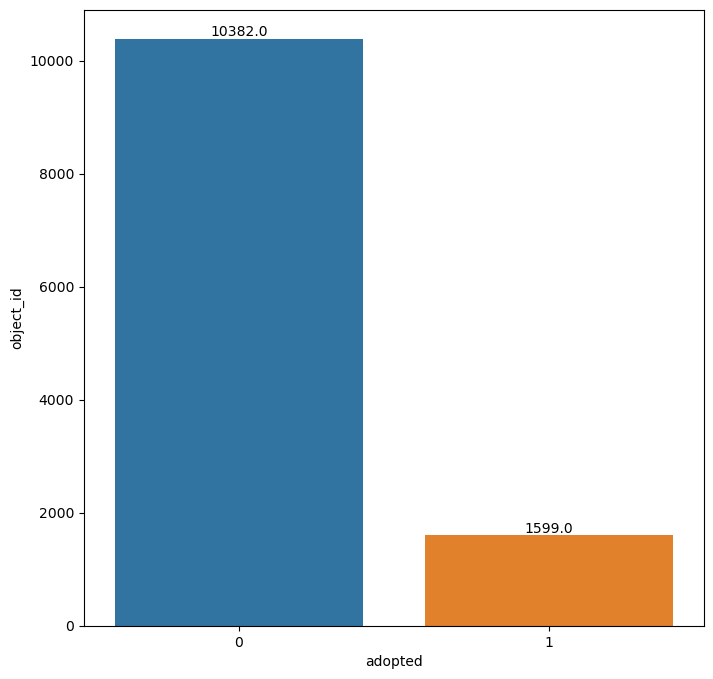

In [27]:
_, ax = plt.subplots(1,1,figsize=(8,8))

sns.barplot(data=df_tbl.groupby(['adopted'])['object_id'].count().reset_index(), x='adopted',y='object_id', ax=ax)

for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height +.01,
                f'{height}',
                ha='center', va='bottom')

plt.show()

    There are considerably more non-adopted users than adopted.
    
### Creation source:

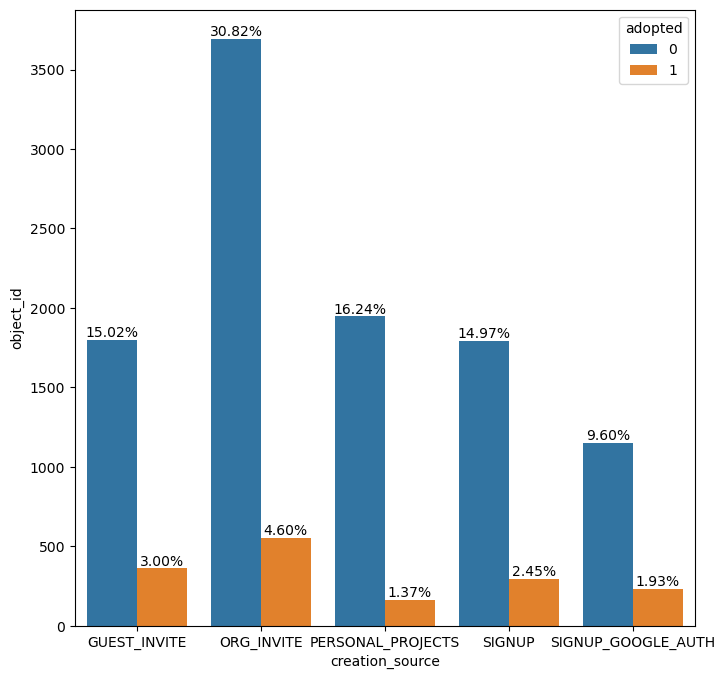

In [28]:
_, ax = plt.subplots(1,1,figsize=(8,8))

sns.barplot(data=df_tbl.groupby(['creation_source','adopted'])['object_id'].count().reset_index(), x='creation_source',y='object_id',hue='adopted', ax=ax)

for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height +.01,
                f'{height/df_tbl.shape[0]:.2%}',
                ha='center', va='bottom')

plt.show()

    The majority of users have signed up through an organizational invite, and that while this group also has the highest number of adopted individuals the categories that have almost comparable levels of adopted users are Guest invites and individuals signing up for personal projects. 

### Mailing list:

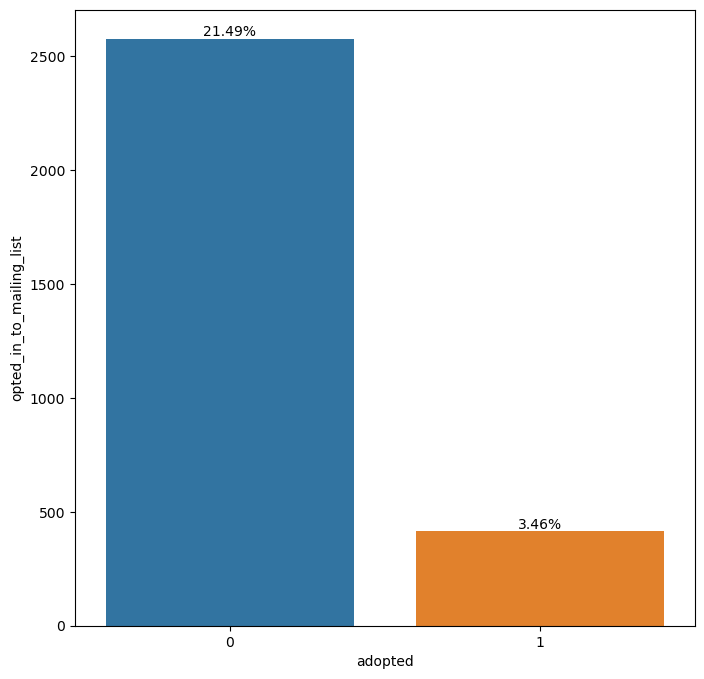

In [29]:
_, ax = plt.subplots(1,1,figsize=(8,8))

sns.barplot(data=df_tbl.groupby(['adopted'])['opted_in_to_mailing_list'].sum().reset_index(), x='adopted',y='opted_in_to_mailing_list', ax=ax)

for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height +.01,
                f'{height/df_tbl.shape[0]:.2%}',
                ha='center', va='bottom')
        
plt.show()

    It would appear that the total number of users that have opted in to the mailing list is roughly 25% of the users. 4.7% of those are considered adopted, while the other 20% are not adopted.

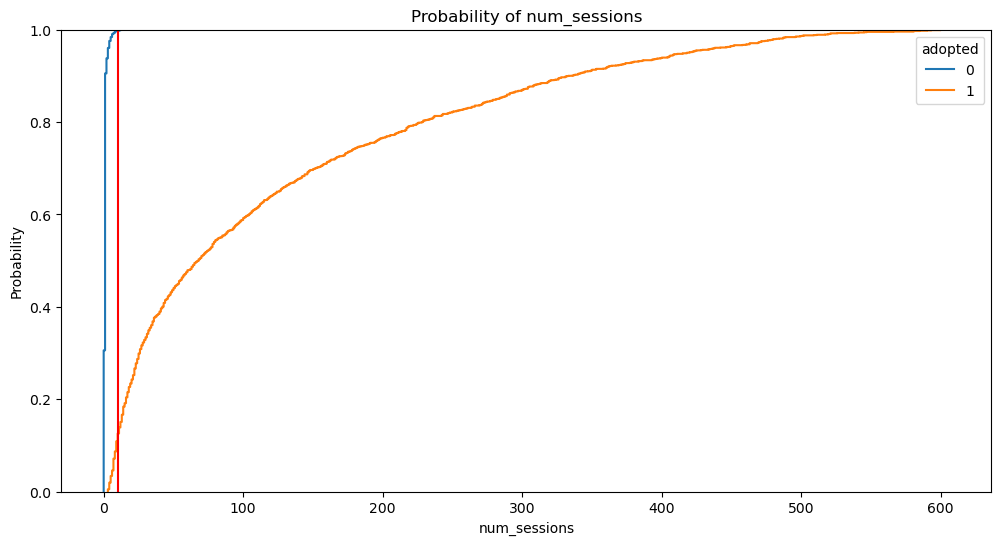

In [30]:
_ , ax = plt.subplots(1,1,figsize=(12,6))

sns.ecdfplot(data=df_tbl, x='num_sessions', hue='adopted',ax=ax,stat='proportion')

ax.set_ylabel('Probability')
ax.set_title('Probability of num_sessions')
ax.axvline(10, color='red')
plt.show()

    As one would expect there is a huge difference in the overall number of sessions between adopted and non-adopted users. Indeed the ECDF for non-adopted users indicates that almost all non-adopted user has used the service less than 10 times.

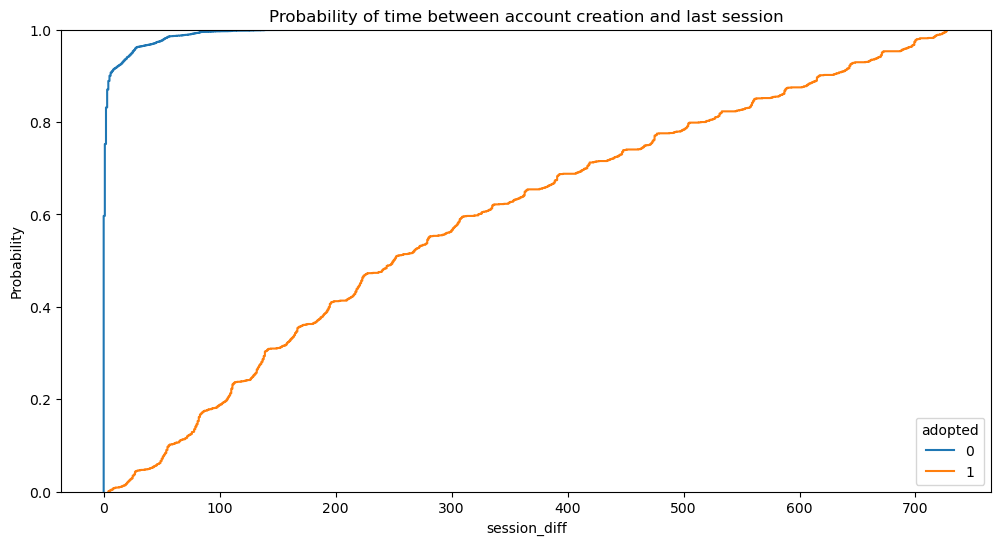

In [31]:
_ , ax = plt.subplots(1,1,figsize=(12,6))

sns.ecdfplot(data=df_tbl, x='session_diff', hue='adopted',ax=ax,stat='proportion')

ax.set_ylabel('Probability')
ax.set_title('Probability of time between account creation and last session')

plt.show()

   Similarly to the number of sessions per user_id, we see that for the time between account creating and last created session there is almost a uniform distribution for adopted users, with a large number of non-adopted users either not creating new sessions at all or having a low number of days since account creation. 

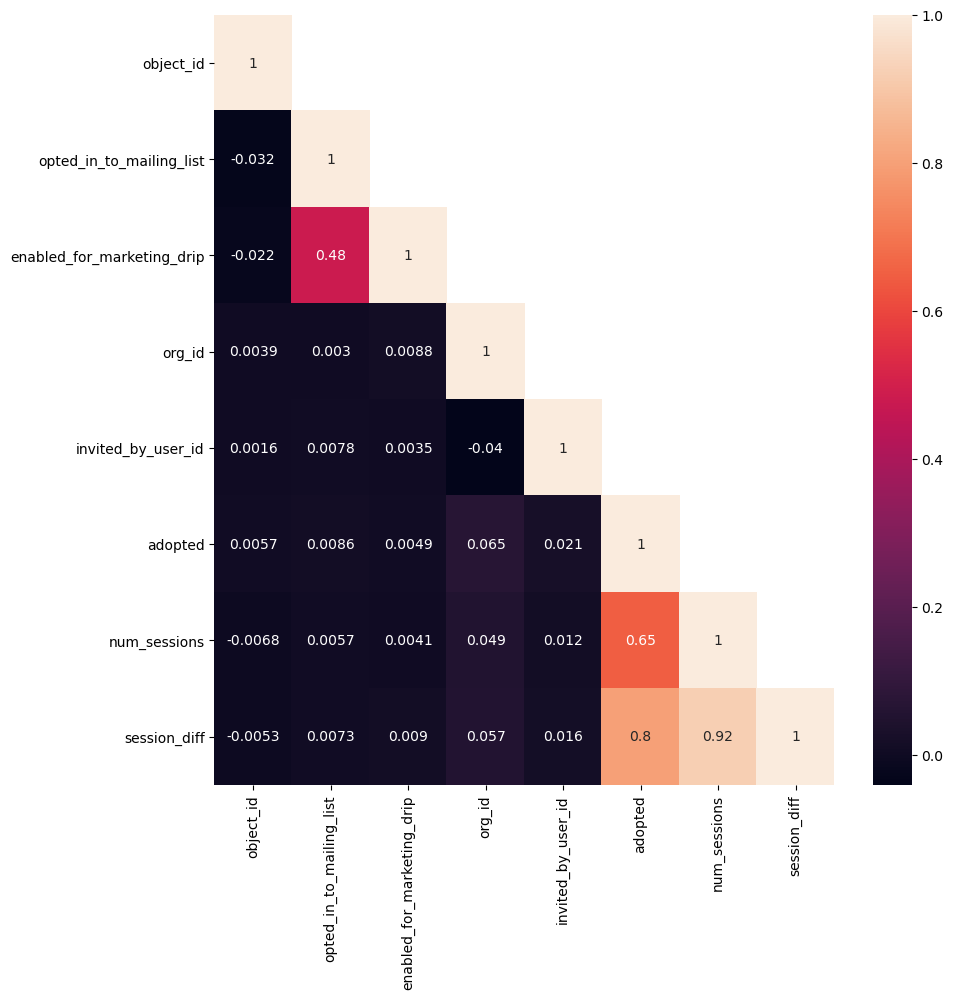

In [32]:
_, ax = plt.subplots(1,1,figsize=(10,10))

c = df_tbl.corr(method='pearson')

mask = np.triu(np.ones_like(c),k=1)

sns.heatmap(c, mask=mask, annot=True, ax=ax)

plt.show()

In [33]:
df_tbl.set_index('object_id', inplace=True)
df_tbl.drop(columns=['num_sessions'], inplace=True)


In [62]:
df_tbl.drop(columns=['session_diff'], inplace=True)

In [63]:
df_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11981 entries, 1 to 12000
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             11981 non-null  object 
 1   opted_in_to_mailing_list    11981 non-null  int64  
 2   enabled_for_marketing_drip  11981 non-null  int64  
 3   org_id                      11981 non-null  int64  
 4   invited_by_user_id          11981 non-null  float64
 5   adopted                     11981 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 655.2+ KB


In [64]:

target='adopted'
num_cols = ['org_id',]
cat_cols = [col for col in df_tbl if col not in ['adopted','org_id']]

In [65]:
X,y = pd.concat([df_tbl[num_cols],pd.get_dummies(df_tbl[cat_cols])], axis=1), df_tbl[target]

In [66]:
X

,org_id,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,
1,11,1,0,10803.0,1,0,0,0,0
2,1,0,0,316.0,0,1,0,0,0
3,94,0,0,1525.0,0,1,0,0,0
4,1,0,0,5151.0,1,0,0,0,0
5,193,0,0,5240.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
11996,89,0,0,8263.0,0,1,0,0,0
11997,200,0,0,0.0,0,0,0,0,1
11998,83,1,1,8074.0,1,0,0,0,0


In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [68]:
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
from hyperopt.early_stop import no_progress_loss

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [71]:
cv_f1_rf = cross_val_score(RandomForestClassifier(),X_train,y_train, cv=5, n_jobs=-1)

In [72]:
cv_f1_rf.mean()

0.818149001814495

In [73]:
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)

y_preds = rf1.predict(X_test)

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      3135
           1       0.17      0.09      0.12       460

    accuracy                           0.83      3595
   macro avg       0.52      0.51      0.51      3595
weighted avg       0.79      0.83      0.80      3595



In [74]:
def acc_model(params, n_folds=5):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train, cv=n_folds, n_jobs=-1, scoring='f1').mean()

BEST = 0
def obj_fcn(params):
    
    global BEST
    
    acc = acc_model(params)
    if acc > BEST:
        BEST=acc
    print ('new best:', BEST, params)
    return{'loss': 1 - acc, 'status': STATUS_OK}

param_space = {
    'max_depth': hp.choice('max_depth', range(2,5)),
    'max_features': hp.choice('max_features', range(1,X.shape[1])),
    'n_estimators': hp.choice('n_estimators', range(100,500))
}


In [75]:
trials = Trials()
best = fmin(obj_fcn, param_space, algo=tpe.suggest, max_evals=20, trials=trials, rstate=np.random.seed(1), early_stop_fn=no_progress_loss(5) )

print('best:\n', best)

new best:                                             
0                                                     
{'max_depth': 3, 'max_features': 4, 'n_estimators': 256}
new best:                                                        
0                                                                
{'max_depth': 4, 'max_features': 5, 'n_estimators': 180}         
new best:                                                        
0                                                                
{'max_depth': 3, 'max_features': 8, 'n_estimators': 208}         
new best:                                                        
0                                                                
{'max_depth': 4, 'max_features': 4, 'n_estimators': 118}         
new best:                                                        
0                                                                
{'max_depth': 4, 'max_features': 3, 'n_estimators': 315}         
 25%|██▌       | 5/20 [00:14<00:43,  2.89

In [76]:
rf_mod = RandomForestClassifier(n_estimators=256, max_features=4, max_depth=3, criterion='gini')
rf_mod.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=4, n_estimators=256)

In [78]:
y_preds = rf_mod.predict(X_test)

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3135
           1       0.00      0.00      0.00       460

    accuracy                           0.87      3595
   macro avg       0.44      0.50      0.47      3595
weighted avg       0.76      0.87      0.81      3595



/home/thomas/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
feat_imps_rf = pd.Series(rf1.feature_importances_, X_train.columns).sort_values(ascending=False)

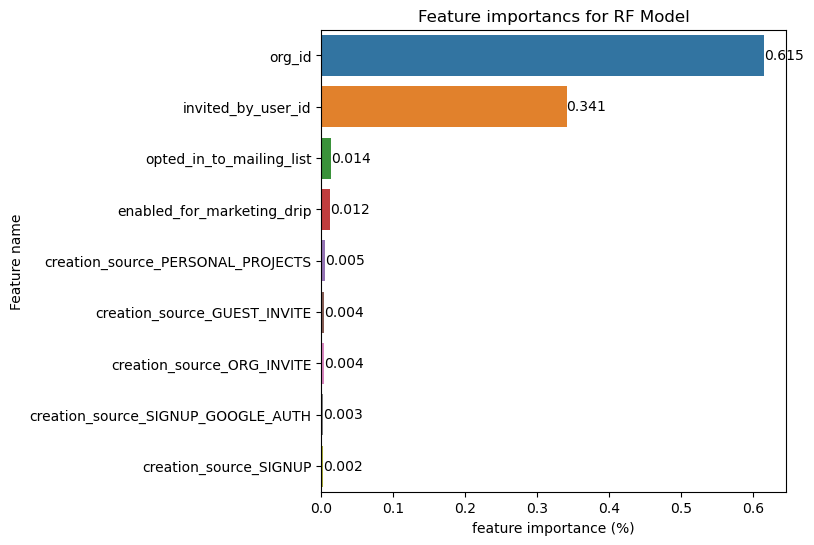

In [80]:
_, ax = plt.subplots(1,1,figsize=(6,6))

sns.barplot(data= feat_imps_rf.reset_index(), x=0, y='index', ax=ax)
for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width(), rect.get_y() +height/2,
                f'{rect.get_width():.3f}',
                ha='left', va='center')
        
ax.set_title('Feature importancs for RF Model')
ax.set_xlabel('feature importance (%)')
ax.set_ylabel('Feature name')

plt.show()

In [81]:
feat_imps_rf = pd.Series(rf_mod.feature_importances_, X_train.columns).sort_values(ascending=False)

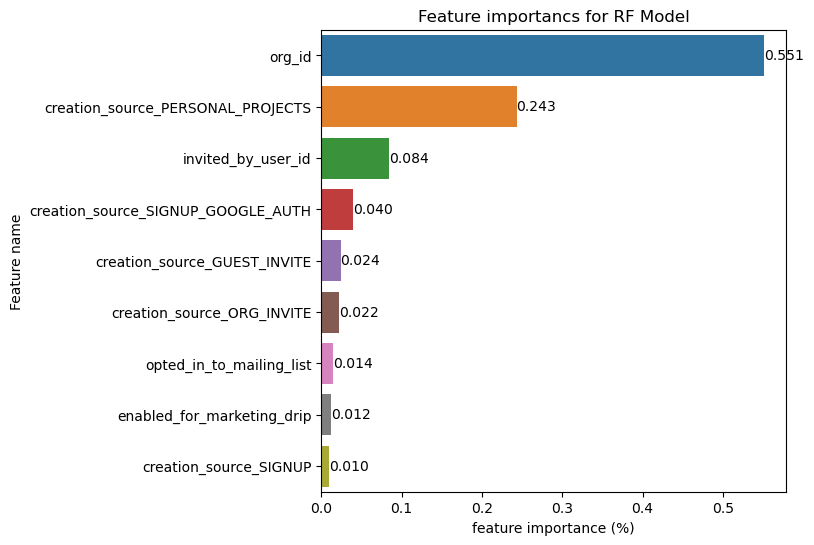

In [82]:
_, ax = plt.subplots(1,1,figsize=(6,6))

sns.barplot(data= feat_imps_rf.reset_index(), x=0, y='index', ax=ax)
for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width(), rect.get_y() +height/2,
                f'{rect.get_width():.3f}',
                ha='left', va='center')
        
ax.set_title('Feature importancs for RF Model')
ax.set_xlabel('feature importance (%)')
ax.set_ylabel('Feature name')

plt.show()

In [54]:
rf_mod = RandomForestClassifier(n_estimators=223, max_features=10, max_depth=3, criterion='gini')
rf_mod.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=10, n_estimators=223)

    Until now I have explored the relationships between "adopted" and "non-adopted" users. Using the definition of adopted user in the brief, I used a pivot table to resample the values for each user in the user_engagement dataset and performed a sum over a rolling window to see their engagement over abritrary windows of time. I chose to do this because the pandas Grouper function discretizes the bins it looks at. Doing this we Identified 1599 users as "adopted".
    
    Furthermore it was found that on average adopted users log in more often and spend more time interacting with the service. When trying to use features that capture length of time/amount of interaction with the product, the trained models vastly overfit to those fits, when they are removed the models perform very poorly while distributing feature importances more evenly.
    
    This is a strong indicator that other features are going to be needed to better answer this problem. For example, with the previous practice assessment there were metrics on driver behavior in the first 30 days since activation. 

In [117]:
attempt = df_eng.groupby([pd.Grouper(key='time_stamp',freq='30D'),'user_id'])['visited'].sum().reset_index()

In [118]:
attempt.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [119]:
attempt.visited.unique()

array([ 1,  2,  5,  6,  9,  3,  4, 14,  8, 11,  7, 10, 13])

In [110]:
df_tbl.reset_index()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,GUEST_INVITE,1,0,11,10803.0,0
1,2,ORG_INVITE,0,0,1,316.0,1
2,3,ORG_INVITE,0,0,94,1525.0,0
3,4,GUEST_INVITE,0,0,1,5151.0,0
4,5,GUEST_INVITE,0,0,193,5240.0,0
...,...,...,...,...,...,...,...
11976,11996,ORG_INVITE,0,0,89,8263.0,0
11977,11997,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,0
11978,11998,GUEST_INVITE,1,1,83,8074.0,0
11979,11999,PERSONAL_PROJECTS,0,0,6,0.0,0


In [125]:
missing_vals = [usr for usr in df_tbl.reset_index().object_id.values if usr not in attempt.user_id.values]

In [122]:
full = pd.concat([pd.DataFrame({'user_id':missing_vals, 'visited':0}),attempt[['user_id','visited']]], axis=0)

In [123]:
full.sort_values(by='user_id', ascending=True, inplace=True)

In [132]:
full = full[full.user_id.isin(df_tbl.index.values.tolist())]

In [133]:
full.shape

(11981, 2)

In [134]:
df_tbl['first_30'] = full.visited.values

In [135]:
target='adopted'
num_cols = ['org_id','first_30']
cat_cols = [col for col in df_tbl if col not in ['adopted','org_id','first_30']]

In [136]:
X,y = pd.concat([df_tbl[num_cols],pd.get_dummies(df_tbl[cat_cols])], axis=1), df_tbl[target]

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [139]:
trials = Trials()
best = fmin(obj_fcn, param_space, algo=tpe.suggest, max_evals=20, trials=trials, rstate=np.random.seed(1), early_stop_fn=no_progress_loss(5) )

print('best:\n', best)

new best:                                             
0.597257899193312                                     
{'max_depth': 2, 'max_features': 6, 'n_estimators': 493}
new best:                                                                        
0.5994790156420264                                                               
{'max_depth': 2, 'max_features': 7, 'n_estimators': 297}                         
new best:                                                                        
0.5994790156420264                                                               
{'max_depth': 3, 'max_features': 8, 'n_estimators': 106}                         
new best:                                                                        
0.5994790156420264                                                               
{'max_depth': 2, 'max_features': 2, 'n_estimators': 299}                         
new best:                                                                        
0.59947901564

In [140]:
rf_2 = RandomForestClassifier(n_estimators=297, max_depth=2, max_features=7)
rf_2.fit(X_train, y_train)
y_preds = rf_2.predict(X_test)

print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3135
           1       0.60      0.52      0.56       460

    accuracy                           0.89      3595
   macro avg       0.77      0.74      0.75      3595
weighted avg       0.89      0.89      0.89      3595



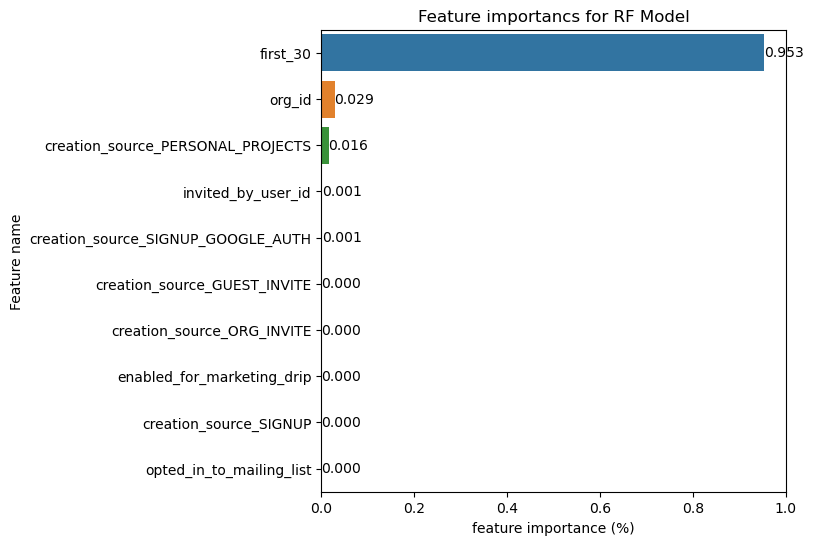

In [141]:
feat_imps_rf = pd.Series(rf_2.feature_importances_, X_train.columns).sort_values(ascending=False)

_, ax = plt.subplots(1,1,figsize=(6,6))

sns.barplot(data= feat_imps_rf.reset_index(), x=0, y='index', ax=ax)
for rect in ax.patches:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width(), rect.get_y() +height/2,
                f'{rect.get_width():.3f}',
                ha='left', va='center')
        
ax.set_title('Feature importancs for RF Model')
ax.set_xlabel('feature importance (%)')
ax.set_ylabel('Feature name')

plt.show()

    By quickly creating some semblance of the number of log ins in the first 30 days since an account is acctivated shows that there is vast improvement in the model performance and indeed we see that almost of the importance is put onto that one feature.

    For future considerations on this problem I would play aroud with other models to see what peforms best on this problem. I would also make a point of updating data collection for this data set to include more metrics on first 30 day interactions.